# A1：全连接网络
2022210085 臧泽元
****
## TL;DR
- 任务：训练一个**全连接神经网络**分类器，完成图像分类 (20 points)
- 数据：[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

本实验使用 `numpy` 构建了一个三层全连接神经网络，采用了模块化设计，在 CIFAR-10 数据集进行训练和测试，实现了超过50%的分类准确率

网络架构如下：
```plaintext
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   

               Input   #####      3   32   32
             Flatten   ||||| -------------------         0
                       #####        3072
(BatchNormalization)    μ|σ  -------------------         0
                       #####        3072                 
               Dense   XXXXX -------------------    393216
          Activation   #####         128
(BatchNormalization)    μ|σ  -------------------
                       #####         128
               Dense   XXXXX -------------------      8192
          Activation   #####          64
(BatchNormalization)    μ|σ  -------------------
                       #####          64
               Dense   XXXXX -------------------       640
             softmax   #####          10
```

## 1 前置知识
全连接前馈神经网络是最早发明的一类人工神经网络，其中各神经元处于不同的层中，每一层神经元接收上一层神经元的信号，并产生信号输出到下一层。第 0 层称为输入层，最后一层称为输出层，其他中间层称为隐藏层。整个网络中无反馈，信号从输入层向输出层单向传播，可用一个有向无环图表示。
### 1.1 前向传播
描述前馈神经网络的记号主要有：
- $L$：神经网络层数
- $M_l$：第 $l$ 层神经元个数
- $\sigma_l(\cdot)$：第 $l$ 层神经元的激活函数
- $\boldsymbol W^{l}\in\mathbb{R}^{M_l\times M_{l-1}}$：第 $l-1$ 层到第 $l$ 层的权重矩阵
- $\boldsymbol b^{l}\in\mathbb{R}^{M_l}$：第 $l-1$ 层到第 $l$ 层的偏置
- $\boldsymbol z^{l}\in\mathbb{R}^{M_l}$：第 $l$ 层神经元的净输入 (净活性值)
- $\boldsymbol a^{l}\in\mathbb{R}^{M_l}$：第 $l$ 层神经元的输出 (活性值)

$\omega_{jk}^l$ 为从第 $l-1$ 层的第 $k$ 个神经元到第 $l$ 层的第 $j$ 个神经元的连接的权重，$b_j^l$ 为第 $l$ 层中第 $j$ 个神经元的偏置，$a_j^l$ 为第 $l$ 层中第 $j$ 个神经元的激活值，则有$$a_j^l=\sigma\left(\sum_k\omega_{jk}^l a_k^{l-1}+b_j^l\right)$$其中 $\sigma$ 是第 $j$ 个神经元的激活函数，总和包括第 $l-1$ 层的所有神经元 $k$. 使用向量化表示可转化为$$\boldsymbol a^l = \boldsymbol \sigma_l\left(\boldsymbol W^l \boldsymbol a^{l-1}+\boldsymbol b^l\right)$$上述公式表明了某一层的激活向量如何与前一层的激活向量相关。
### 1.2 损失函数
在 CIFAR-10 数据集上进行图像分类属于多分类问题，输出层神经元的激活向量可以表示为$$\boldsymbol a^L=\boldsymbol \sigma^L\left(\boldsymbol z^L\right)$$预测输出 $\hat y=\text{softmax}\left(\boldsymbol a^L\right)$，在类别数量差异不大的情况下可以采用交叉熵损失函数$$J = -\frac{1}{N}\sum{y\log(\hat y)}$$
### 1.3 反向传播
定义误差 $\delta_j^l$ 为第 $l$ 层中第 $j$ 个神经元的误差 $$\delta_j^l=\frac{\partial J}{\partial z_j^l}$$ $\delta^l$ 为第 $l$ 层的误差向量，$\delta^L$ 为输出层的误差向量，可导出下面四个基本等式：
$$\begin{align}
\delta_j^L&=\frac{\partial J}{\partial a_j^L}\sigma^\prime\left(z_j^L\right)\tag{BP1}\\
\delta^l&=\left(\left(\boldsymbol W^{l+1}\right)^T\delta^{l+1}\right)\odot\sigma^\prime\left(z^l\right)\tag{BP2}\\
\frac{\partial J}{\partial\omega_{jk}^l}&=a_k^{l-1}\delta_j^l\tag{BP3}\\
\frac{\partial J}{\partial b_j^l}&=\delta_j^l\tag{BP4}
\end{align}$$
计算时，首先为输入层设置相应的激活值 $\boldsymbol a^1$，然后进行前馈，得到每一层的 $\boldsymbol z^l$ 和 $\boldsymbol a^l$，再计算输出层误差 $\delta^L$，根据 $(\text{BP2})$ 进行误差反向传播，得到误差函数的梯度 $\frac{\partial J}{\partial \omega_{jk}^l}$ 和 $\frac{\partial J}{\partial b_j^l}$.
得到误差函数的梯度后，就可以通过梯度下降法更新参数（无正则化）：
$$\begin{align}
\frac{\partial J}{\partial \omega_{jk}^l} &= \left[\frac{\partial J}{\partial \boldsymbol W^l}\right]_{jk}\nonumber\\
&=\left[\delta^l\cdot(\boldsymbol a^{l-1})^T\right]_{jk}\nonumber\\
\frac{\partial J}{\partial \boldsymbol W^l}&=\delta^l\cdot(\boldsymbol a^{l-1})^T\nonumber\\
\frac{\partial J}{\partial \boldsymbol b^l}&=\delta^l\nonumber\\
\boldsymbol W^l &\gets\boldsymbol W^l-\alpha\frac{\partial J}{\partial \boldsymbol W^l}\nonumber\\
\boldsymbol b^l &\gets\boldsymbol b^l-\alpha\frac{\partial J}{\partial \boldsymbol b^l}\nonumber
\end{align}$$

## 2 引入库并初始化数据

In [1]:
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


在数据初始化过程中，需要对训练数据由 $[0,255]$ 归一化到 $[0,1]$ 区间，测试数据中 10 类标签进行独热编码得到 10 维向量。

归一化在本实验中的目的有：
1. 减少权重变化剧烈的情况，使网络在训练时更加稳定，减少梯度爆炸和梯度消失的问题
2. 加速网络收敛，使得模型能更快找到全局最优解
3. 防止数值溢出

独热编码的目的有：
1. 将离散的类别标签转化为二进制向量，适合分类任务的损失函数与输出层设计
2. 避免标签大小数值对模型的影响（如模型可能认为 0-9 十类之间存在大小排序关系）

In [2]:
import numpy as np
import pickle
import os
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## 加载数据集
def load_CIFAR_batch(filename):
  with open(filename, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

def load_CIFAR10(cifar10_dir):
  xs, ys = [], []
  for i in range(1,6):
    train_batch = load_CIFAR_batch(cifar10_dir + "/data_batch_" + str(i))
    xs.append(train_batch[b'data'])
    ys.append(train_batch[b'labels'])
  X_train = np.concatenate(xs)
  y_train = np.concatenate(ys)

  test_batch = load_CIFAR_batch(cifar10_dir + "/test_batch")
  X_test = np.array(test_batch[b'data'])
  y_test = np.array(test_batch[b'labels'])

  return X_train, y_train, X_test, y_test

## 像素值归一化
def normalize(X): return X / 255.0

## 独热编码
def one_hot_encode(y, num_classes):
  one_hots = np.zeros((y.shape[0], num_classes))
  one_hots[np.arange(y.shape[0]), y] = 1
  return one_hots

X_train, y_train, X_test, y_test = load_CIFAR10('cifar-10-batches-py')

X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = one_hot_encode(y_train, 10)
y_test = one_hot_encode(y_test, 10)

**数据示例**

In [3]:
X_train, X_test, y_train, y_test

(array([[0.23137255, 0.16862745, 0.19607843, ..., 0.54901961, 0.32941176,
         0.28235294],
        [0.60392157, 0.49411765, 0.41176471, ..., 0.54509804, 0.55686275,
         0.56470588],
        [1.        , 0.99215686, 0.99215686, ..., 0.3254902 , 0.3254902 ,
         0.32941176],
        ...,
        [0.1372549 , 0.15686275, 0.16470588, ..., 0.30196078, 0.25882353,
         0.19607843],
        [0.74117647, 0.72941176, 0.7254902 , ..., 0.6627451 , 0.67058824,
         0.67058824],
        [0.89803922, 0.9254902 , 0.91764706, ..., 0.67843137, 0.63529412,
         0.63137255]]),
 array([[0.61960784, 0.62352941, 0.64705882, ..., 0.48627451, 0.50588235,
         0.43137255],
        [0.92156863, 0.90588235, 0.90980392, ..., 0.69803922, 0.74901961,
         0.78039216],
        [0.61960784, 0.61960784, 0.54509804, ..., 0.03137255, 0.01176471,
         0.02745098],
        ...,
        [0.07843137, 0.0745098 , 0.05882353, ..., 0.19607843, 0.20784314,
         0.18431373],
        [0.0

训练集由 50000 组数据构成，测试集由 10000 组数据构成，每一张图片为 32x32x3 RGB 图像，经处理后展平为长度 3072 的一维向量，每一条结果经独热编码后为长度 10 的一维向量。

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 3072), (10000, 3072), (50000, 10), (10000, 10))

## 3 网络设计
为了便于让网络设计更加简洁、可维护和可扩展，本实验采用模块化的思路，将各层定义为独立的类并单独设置超参数。
### 3.1 全连接层类
#### 3.1.1 数学推导
对于一个全连接层，在前向传播中，对于输入 $X$ 和权重矩阵 $W$，输出 $Z$ 可以表示为：$$Z = W \cdot X + b$$权重梯度 $dW$ 的推导如下：$$
dW = \frac{\partial L}{\partial W} = \frac{\partial L}{\partial Z} \cdot \frac{\partial Z}{\partial W}$$通过链式法则可以得出：$$dW = dZ \cdot X^T$$偏置梯度 $db$ 的推导如下：$$db = \frac{\partial L}{\partial b} = \frac{\partial L}{\partial Z} \cdot \frac{\partial Z}{\partial b}$$由于偏置 $b$ 是一个常数项，并且与每个样本的输出 $Z$ 有相同的形状：$$db = \sum_{i=1}^{m} dZ_i = \frac{1}{m} \sum_{i=1}^{m} dZ_i$$这里的 $db$ 是对每个神经元的偏置的总和（平均），因此最终结果的形状是 (k, 1).
输入梯度  dX  的推导如下：$$dX = \frac{\partial L}{\partial X} = \frac{\partial L}{\partial Z} \cdot \frac{\partial Z}{\partial X}$$通过链式法则可以得出：$$dX = W^T \cdot dZ$$据此可以得出全连接层类代码：

In [5]:
class FullyConnectedLayer:
  def __init__(self, input_size, output_size, weight_scale=0.1, init_method='normal'):
    self.input_size = input_size
    self.output_size = output_size
    self.init_method = init_method

    ## 权重和偏置初始化
    if init_method == 'normal':
      self.W = np.random.randn(output_size, input_size) * weight_scale
    elif init_method == 'uniform':
      self.W = np.random.uniform(low=-weight_scale, high=weight_scale, size=(output_size, input_size))
    elif init_method == 'equal':
      self.W = np.full((output_size, input_size), weight_scale)
    elif init_method == 'xavier':
      self.W = np.random.randn(output_size, input_size) * np.sqrt(1.0 / (input_size + output_size))
    elif init_method == 'kaiming':
      self.W = np.random.randn(output_size, input_size) * np.sqrt(2.0 / input_size)
    else:
      raise ValueError("Unsupported initialization method")

    self.b = np.zeros((output_size, 1))

  def forward(self, X):
    ## 前向传播，计算 Z = W * X + b
    self.X = X
    self.Z = np.dot(self.W, X) + self.b
    return self.Z

  def backward(self, dZ, optimizer):
    ## 反向传播，计算 dW, db, dX 并更新 W, b
    m = self.X.shape[1] # 样本数
    self.dW = np.dot(dZ, self.X.T) / m
    self.db = np.sum(dZ, axis=1, keepdims=True) / m
    dX = np.dot(self.W.T, dZ)

    optimizer.update(self)

    return dX # 返回上一层的梯度

### 3.2 激活函数类
#### 3.2.1 Softmax 激活函数
用于多分类输出层

**公式**：

$$\text{Softmax}(x)=\frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [6]:
class Softmax:
  def forward(self, Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True)) #防止指数爆炸
    self.A = expZ / np.sum(expZ, axis=0, keepdims=True)
    return self.A

  def backward(self, dA):
    return dA

#### 3.2.2 ReLU 激活函数
**公式**：

$$\text{ReLU}(x)=\max(0,x)$$

In [7]:
class ReLU:
  def forward(self,Z):
    self.Z = Z
    return np.maximum(0, Z)

  def backward(self, dA, learning_rate=None):
    dZ = np.array(dA, copy=True)
    dZ[self.Z <= 0] = 0
    return dZ

#### 3.2.3 Sigmoid 激活函数
**公式**：

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

$$\sigma^{\prime}(x)=\sigma(x)\left(1-\sigma(x)\right)$$

In [8]:
class Sigmoid:
  def forward(self, Z):
    self.A = 1 / (1 + np.exp(-Z))
    return self.A

  def backward(self, dA, learning_rate=None):
    return dA * self.A * (1 - self.A)

#### 3.2.4 Tanh 激活函数
**公式**：
$$\tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$
$$\tanh^{\prime}(x)=1-\tanh^2(x)$$

In [9]:
class Tanh:
  def forward(self, Z):
    self.A = np.tanh(Z)
    return self.A
  def backward(self, dA, learning_rate=None):
    return dA * (1 - np.square(self.A))

#### 3.2.5 Leaky ReLU 激活函数
**公式**：

$$\begin{align}\text{LeakyReLU}(x)&=\left\{\begin{matrix}
x\enspace\enspace\text{if}\space x\gt 0 \\
\gamma x \enspace\enspace\text{if}\space x\le 0
\end{matrix}\right.\nonumber\\&=\max(0,x)+\gamma\min(0,x)\nonumber\end{align}$$

通常设置 $\gamma=0.01$

In [10]:
class LeakyReLU:
  def __init__(self, alpha=0.01):
    self.alpha = alpha

  def forward(self, Z):
    self.Z = Z
    return np.where(Z > 0, Z, Z * self.alpha)

  def backward(self, dA, learning_rate=None):
    dZ = np.array(dA, copy=True)
    dZ[self.Z <= 0] *= self.alpha
    return dZ

### 3.3 损失函数类
#### 3.3.1 交叉熵损失函数

In [11]:
class CrossEntropyLoss:
  def forward(self, A, y_true):
    m = y_true.shape[1]
    self.A = A
    self.y_true = y_true
    y_true_indices = np.argmax(y_true, axis=0)
    log_probs = -np.log(A[y_true_indices, range(m)])
    loss = np.sum(log_probs) / m
    return loss

  def backward(self):
    m = self.y_true.shape[1]
    dZ = self.A - self.y_true
    return dZ / m

#### 3.3.2 均方误差（MSE）损失函数

In [12]:
class MSELoss:
  def forward(self, A, y_true):
    self.A = A
    self.y_true = y_true
    return np.mean((A - y_true) ** 2)

  def backward(self):
    m = self.y_true.shape[1]
    return 2 * (self.A - self.y_true) / m

### 3.4 优化器类

In [13]:
class Optimizer:
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate

  def update(self, layer):
    pass

#### 3.4.1 批量梯度下降

In [14]:
class GD(Optimizer):
  def update(self, layer):
    layer.W -= self.learning_rate * layer.dW
    layer.b -= self.learning_rate * layer.db

#### 3.4.2 动量法

In [15]:
class Momentum(Optimizer):
  def __init__(self, learning_rate, momentum=0.9):
    super().__init__(learning_rate)
    self.momentum = momentum
    self.vW = {}
    self.vb = {}

  def update(self, layer):
    if layer not in self.vW:
      self.vW[layer] = np.zeros_like(layer.W)
      self.vb[layer] = np.zeros_like(layer.b)
    self.vW[layer] = self.momentum * self.vW[layer] + self.learning_rate * layer.dW
    self.vb[layer] = self.momentum * self.vb[layer] + self.learning_rate * layer.db
    layer.W -= self.vW[layer]
    layer.b -= self.vb[layer]

#### 3.4.3 Adam 优化器

In [16]:
class Adam(Optimizer):
  def __init__(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    super().__init__(learning_rate)
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.mW = {}
    self.mb = {}
    self.vW = {}
    self.vb = {}
    self.t = 0

  def update(self, layer):
    if layer not in self.mW:
      self.mW[layer] = np.zeros_like(layer.W)
      self.mb[layer] = np.zeros_like(layer.b)
      self.vW[layer] = np.zeros_like(layer.W)
      self.vb[layer] = np.zeros_like(layer.b)
    self.t += 1
    self.mW[layer] = self.beta1 * self.mW[layer] + (1 - self.beta1) * layer.dW
    self.mb[layer] = self.beta1 * self.mb[layer] + (1 - self.beta1) * layer.db
    self.vW[layer] = self.beta2 * self.vW[layer] + (1 - self.beta2) * (layer.dW ** 2)
    self.vb[layer] = self.beta2 * self.vb[layer] + (1 - self.beta2) * (layer.db ** 2)
    mWh = self.mW[layer] / (1 - self.beta1 ** self.t)
    mbh = self.mb[layer] / (1 - self.beta1 ** self.t)
    vWh = self.vW[layer] / (1 - self.beta2 ** self.t)
    vbh = self.vb[layer] / (1 - self.beta2 ** self.t)
    layer.W -= self.learning_rate * mWh / (np.sqrt(vWh) + self.epsilon)
    layer.b -= self.learning_rate * mbh / (np.sqrt(vbh) + self.epsilon)

### 3.5 归一化方法
#### 3.5.1 Batch Normalization

In [17]:
class BatchNormalization:
  def __init__(self, momentum=0.9, epsilon=1e-5):
    self.momentum = momentum
    self.epsilon = epsilon
    self.running_mean = None
    self.running_var = None
    self.gamma = None
    self.beta = None
  
  def forward(self, X, is_training=True):
    if self.gamma is None:
      self.gamma = np.ones(X.shape[0])
      self.beta = np.zeros(X.shape[0])
    
    if is_training:
      mean = np.mean(X, axis=1, keepdims=True)
      var = np.var(X, axis=1, keepdims=True)
      
      if self.running_mean is None:
        self.running_mean = mean
        self.running_var = var
      else:
        self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
        self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
    
      X_norm = (X - mean) / np.sqrt(var + self.epsilon)
      out = self.gamma.reshape(-1, 1) * X_norm + self.beta.reshape(-1, 1)
      
      self.X_norm = X_norm
      self.X = X
      self.mean = mean
      self.var = var
    else:
      X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
      out = self.gamma.reshape(-1, 1) * X_norm + self.beta.reshape(-1, 1)
    
    return out
  
  def backward(self, dout):
    m = dout.shape[1]
    dX_norm = dout * self.gamma.reshape(-1, 1)
    dvar = np.sum(dX_norm * (self.X - self.mean) * -0.5 * (self.var + self.epsilon) ** -1.5, axis=1, keepdims=True)
    dmean = np.sum(dX_norm * -1 / np.sqrt(self.var + self.epsilon), axis=1, keepdims=True) + dvar * np.mean(-2 * (self.X - self.mean), axis=1, keepdims=True)
    dX = dX_norm / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.X - self.mean) / m + dmean / m
    
    self.dgamma = np.sum(dout * self.X_norm, axis=1)
    self.dbeta = np.sum(dout, axis=1)
    
    return dX

### 3.6 神经网络类
可以将各个层组合起来形成完整的神经网络

In [18]:
class NeuralNetwork:
  def __init__(self, layers, optimizer, loss_fn=CrossEntropyLoss()):
    self.layers = layers
    self.loss_fn = loss_fn
    self.optimizer = optimizer

  def forward(self, X, is_training=True):
    for layer in self.layers:
      if isinstance(layer, BatchNormalization):
        X = layer.forward(X, is_training=is_training)
      else:
        X = layer.forward(X)
    return X

  def backward(self, dZ):
    for layer in reversed(self.layers):
      if isinstance(layer, Softmax):
        dZ = layer.backward(dZ)
      elif isinstance(layer, BatchNormalization):
        dZ = layer.backward(dZ)
      else:
        dZ = layer.backward(dZ, self.optimizer)

  def train_step(self, X, y_true):
    A = self.forward(X, is_training=True)
    loss = self.loss_fn.forward(A, y_true)
    dZ = self.loss_fn.backward()
    self.backward(dZ)
    return loss

  def predict(self, X):
    A = self.forward(X, is_training=False)
    return np.argmax(A, axis=0)

  def save_weights(self):
    weights = []
    for layer in self.layers:
      if isinstance(layer, FullyConnectedLayer):
        weights.append(layer.W.flatten())
    return weights


## 4 训练
### 4.1 训练函数

In [45]:
## 计算准确率
def accuracy(y_true, y_pred):
  return np.mean(y_true == y_pred)

## 训练函数
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, save_interval=10):
  num_samples = X_train.shape[0]
  train_losses = [] # 损失函数值
  val_losses = []
  weights_history = []

  for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, num_samples, batch_size):
      X_batch = X_train[i:i+batch_size].T
      y_batch = y_train[i:i+batch_size].T
      loss = model.train_step(X_batch, y_batch)
      epoch_loss += loss
    
    train_losses.append(epoch_loss / (num_samples // batch_size))

    # 计算验证集损失
    val_loss = 0
    for i in range(0, X_val.shape[0], batch_size):
      X_val_batch = X_val[i:i+batch_size].T
      y_val_batch = y_val[i:i+batch_size].T
      A_val = model.forward(X_val_batch, is_training=False)
      val_loss += model.loss_fn.forward(A_val, y_val_batch)
  
    val_losses.append(val_loss / (X_val.shape[0] // batch_size))

    if (epoch%10 == 0): print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # 定期保存权值
    if (epoch + 1) % save_interval == 0:
      weights_history.append(model.save_weights())
      
  return train_losses, val_losses, weights_history   

## 5 主函数

**可视化权值分布**

In [46]:
def plot_weights_distribution(weights_history, save_interval):
  num_layers = len(weights_history[0])
  num_intervals = len(weights_history)

  fig, axes = plt.subplots(num_layers, num_intervals, figsize=(150, 10))
  if num_layers == 1:
    axes = [axes]
  if num_intervals == 1:
    axes = [[ax] for ax in axes]

  for layer_idx in range(num_layers):
    for interval_idx in range(num_intervals):
      weights = weights_history[interval_idx][layer_idx]
      mean = np.mean(weights)
      std = np.std(weights)
      axes[layer_idx][interval_idx].hist(weights, bins=50)
      axes[layer_idx][interval_idx].set_title(f"Layer {layer_idx+1}, Interval {interval_idx+1}")
      axes[layer_idx][interval_idx].set_xlabel("Weight Value")
      axes[layer_idx][interval_idx].set_ylabel("Frequency")
      
      # 添加均值和方差的标注
      axes[layer_idx][interval_idx].annotate(
        f"Mean: {mean:.2f}\nStd: {std:.2f}",
        xy=(0.95, 0.95),
        xycoords='axes fraction',
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
      )

  plt.savefig('weights_distribution.png')
  plt.show()

In [47]:
if __name__ == "__main__":
  X_train, y_train, X_test, y_test = load_CIFAR10('cifar-10-batches-py')

  X_train = normalize(X_train)
  X_test = normalize(X_test)
  y_train = one_hot_encode(y_train, 10)
  y_test = one_hot_encode(y_test, 10)

  # 定义网络结构
  layers = [
    FullyConnectedLayer(3072, 128, weight_scale=0.01, init_method='uniform'),
    ReLU(),
    FullyConnectedLayer(128, 64, weight_scale=0.01, init_method='uniform'),
    ReLU(),
    FullyConnectedLayer(64, 10, weight_scale=0.01, init_method='uniform'),
    Softmax()
  ]

  # 选择优化器
  optimizer = GD(learning_rate=0.1)

  # 选择损失函数
  loss_fn = CrossEntropyLoss()

  model = NeuralNetwork(layers, optimizer, loss_fn)

  # 训练模型
  train_losses, val_losses, weights_history = train(model, X_train, y_train, X_test, y_test, epochs=1000, batch_size=128, save_interval=50)

  # 计算测试集准确率
  test_preds = model.predict(X_test.T)
  test_acc = accuracy(y_test.argmax(axis=1), test_preds)
  print(f"Test Accuracy: {test_acc:.4f}")  

Epoch 1/1000, Train Loss: 2.3085, Val Loss: 2.3321
Epoch 11/1000, Train Loss: 2.3085, Val Loss: 2.3321
Epoch 21/1000, Train Loss: 2.3084, Val Loss: 2.3320
Epoch 31/1000, Train Loss: 2.3084, Val Loss: 2.3320
Epoch 41/1000, Train Loss: 2.3083, Val Loss: 2.3319
Epoch 51/1000, Train Loss: 2.3082, Val Loss: 2.3318
Epoch 61/1000, Train Loss: 2.3080, Val Loss: 2.3315
Epoch 71/1000, Train Loss: 2.3074, Val Loss: 2.3309
Epoch 81/1000, Train Loss: 2.3057, Val Loss: 2.3291
Epoch 91/1000, Train Loss: 2.2994, Val Loss: 2.3221
Epoch 101/1000, Train Loss: 2.2745, Val Loss: 2.2949
Epoch 111/1000, Train Loss: 2.2115, Val Loss: 2.2308
Epoch 121/1000, Train Loss: 2.1562, Val Loss: 2.1745
Epoch 131/1000, Train Loss: 2.0942, Val Loss: 2.1129
Epoch 141/1000, Train Loss: 2.0721, Val Loss: 2.0922
Epoch 151/1000, Train Loss: 2.0635, Val Loss: 2.0834
Epoch 161/1000, Train Loss: 2.0569, Val Loss: 2.0763
Epoch 171/1000, Train Loss: 2.0505, Val Loss: 2.0693
Epoch 181/1000, Train Loss: 2.0438, Val Loss: 2.0620
Epoc

**画图**

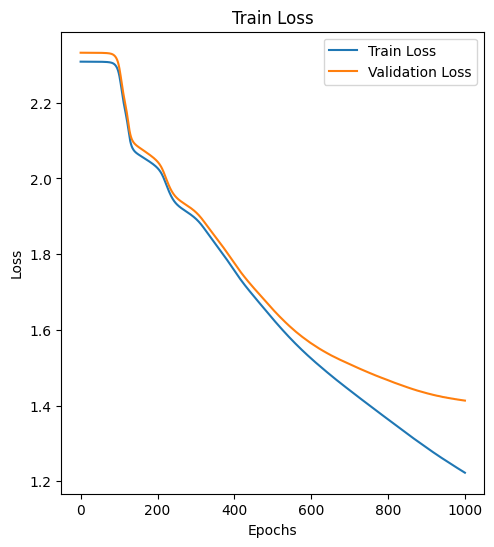

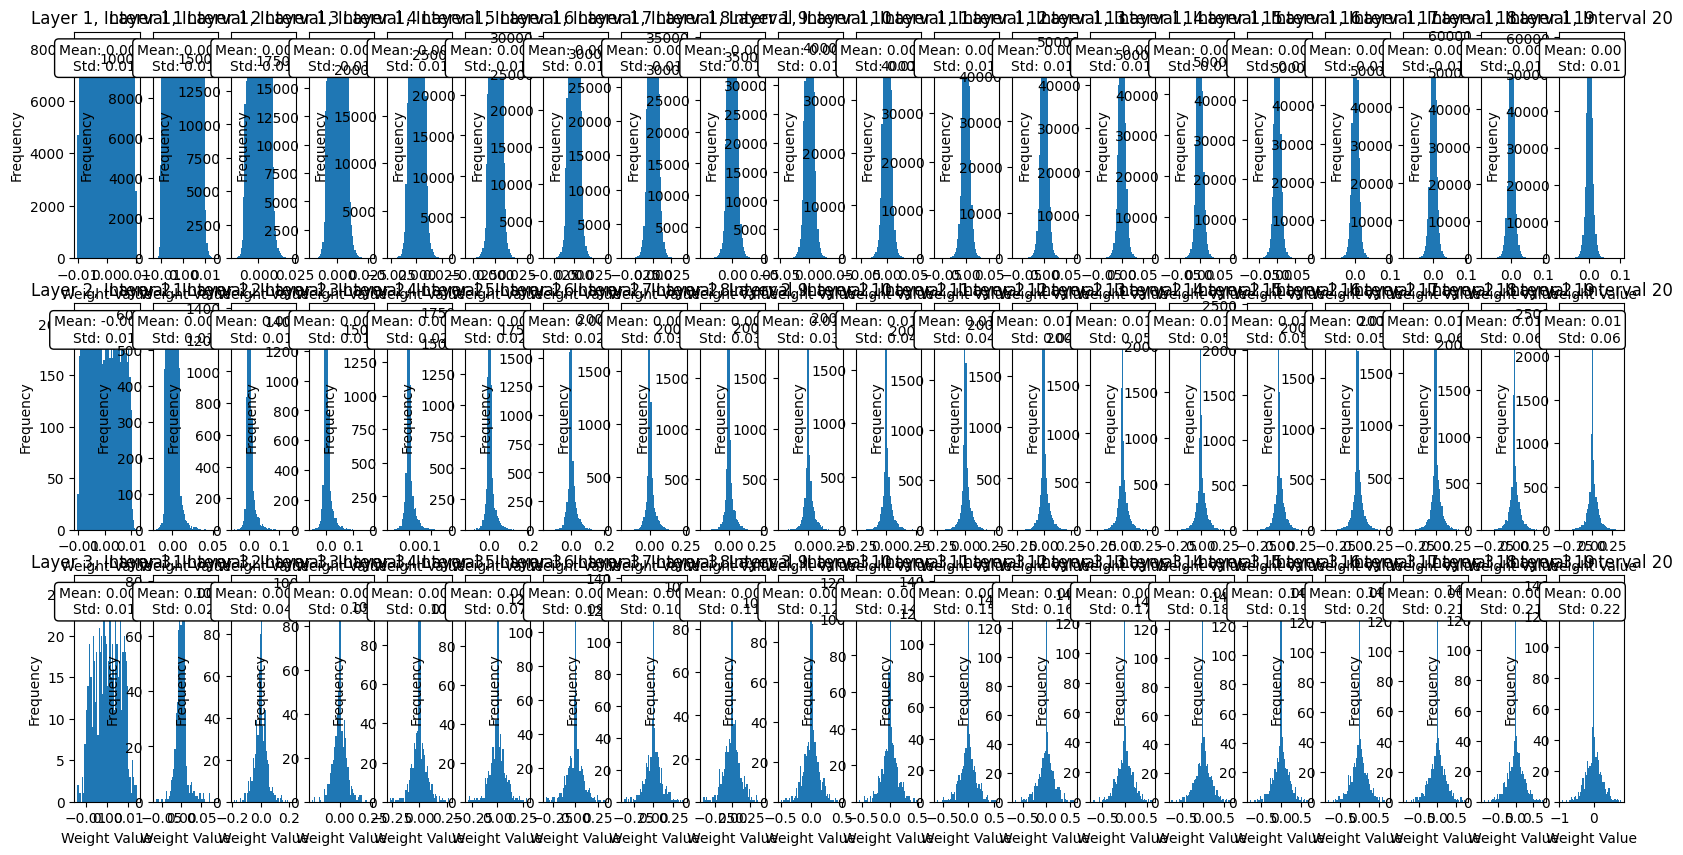

In [48]:
  # 绘制训练损失和验证损失曲线
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train Loss')
  plt.legend()

  plt.savefig('loss_curves.png')
  
  # 绘制权值分布
  plot_weights_distribution(weights_history, save_interval=50)
  